In [1]:
import os
import zipfile
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Getting the data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2021-05-21 20:41:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.206.240, 172.217.18.208, 216.58.214.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.206.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M  7.98MB/s    in 28s     

2021-05-21 20:42:08 (6.85 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2021-05-21 20:42:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.198.208, 216.58.204.112, 216.58.209.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.198.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp

In [3]:
local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [4]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))


total training rock images: 840
total training paper images: 840
total training scissors images: 840


In [5]:
rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

['rock07-k03-119.png', 'rock07-k03-118.png', 'rock07-k03-117.png', 'rock07-k03-116.png', 'rock07-k03-115.png', 'rock07-k03-114.png', 'rock07-k03-113.png', 'rock07-k03-112.png', 'rock07-k03-111.png', 'rock07-k03-110.png']
['paper07-119.png', 'paper07-118.png', 'paper07-117.png', 'paper07-116.png', 'paper07-115.png', 'paper07-114.png', 'paper07-113.png', 'paper07-112.png', 'paper07-111.png', 'paper07-110.png']
['testscissors03-119.png', 'testscissors03-118.png', 'testscissors03-117.png', 'testscissors03-116.png', 'testscissors03-115.png', 'testscissors03-114.png', 'testscissors03-113.png', 'testscissors03-112.png', 'testscissors03-111.png', 'testscissors03-110.png']


# Visualizing the data

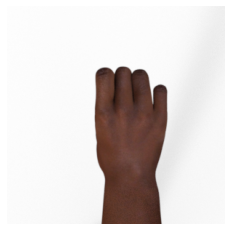

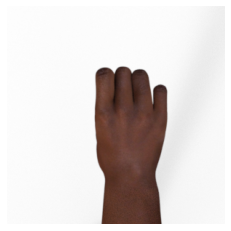

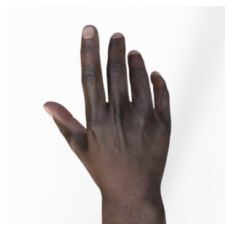

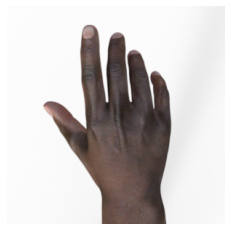

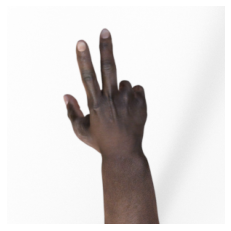

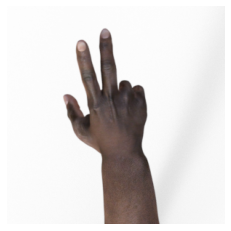

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

# Preprocessing

In [7]:
TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical', # we change to categorical because is more than 2 options
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical',
  batch_size=126
)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# Model

In [8]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') # is not longer relu 
])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Modeling and training 

In [9]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("rps.h5")


Epoch 1/25
20/20 [==============================] - 109s 5s/step - loss: 1.7231 - accuracy: 0.3437 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 108s 5s/step - loss: 1.0812 - accuracy: 0.3901 - val_loss: 1.6248 - val_accuracy: 0.3333
Epoch 3/25
20/20 [==============================] - 106s 5s/step - loss: 1.0937 - accuracy: 0.4282 - val_loss: 1.1625 - val_accuracy: 0.4113
Epoch 4/25
20/20 [==============================] - 106s 5s/step - loss: 0.9988 - accuracy: 0.5079 - val_loss: 1.0299 - val_accuracy: 0.5457
Epoch 5/25
20/20 [==============================] - 105s 5s/step - loss: 0.8133 - accuracy: 0.6063 - val_loss: 0.4196 - val_accuracy: 0.8306
Epoch 6/25
20/20 [==============================] - 105s 5s/step - loss: 0.7730 - accuracy: 0.6627 - val_loss: 0.2960 - val_accuracy: 0.9973
Epoch 7/25
20/20 [==============================] - 106s 5s/step - loss: 0.6559 - accuracy: 0.7337 - val_loss: 0.5807 - val_accuracy: 0.7231
Epoch 8/25
20

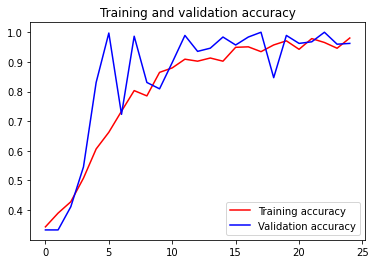

<Figure size 432x288 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()